In [1]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

import os
import sys
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [4]:
MODULE_PATH = os.path.abspath('/storage/zkarwowska/clean_code/data_preparation/') 
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

from processing import MicrobiomeDataPreprocessing, CLRTransformer, MicrobiomeTraintestSplit

MODULE_PATH = os.path.abspath('/storage/zkarwowska/clean_code/data_exploration/') 
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

from ExploreTS import TestStationarity, MakeSeriesStationary

MODULE_PATH = os.path.abspath('/storage/zkarwowska/clean_code/linear_forecasting_models/OLS_regression/') 
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

from regularized_ols_regressions import RidgeModel, LassoModel, ENETModel

## I. PREPARE DATA BEFORE MODELLING

In [5]:
file = '/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets/donorA_rarefied_interpolated_feces.csv'

#### 1. READ DATA

In [6]:
df = pd.read_csv(file, index_col = [0])
df.shape

(365, 1531)

#### 2. FILTER RARE BACTERIA

In [7]:
processing = MicrobiomeDataPreprocessing()
df_filtered = processing.filter_rare_features(df, treshold_perc = .5)
df_filtered.shape

(365, 89)

<AxesSubplot:ylabel='Density'>

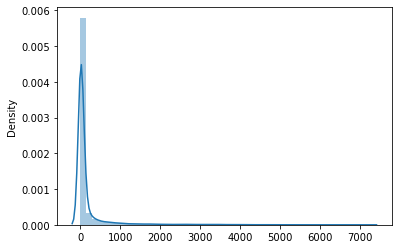

In [8]:
sns.distplot(df_filtered)

#### 3. TRANSFORM USING CLR

In [9]:
transformer = CLRTransformer(is_pseudo_global=True, axis=1)
df_filtered_clr = transformer.fit_transform(df_filtered)

<AxesSubplot:ylabel='Density'>

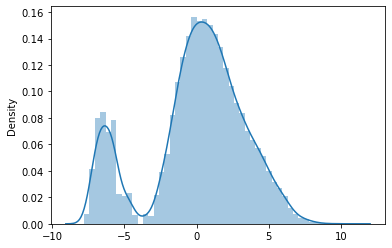

In [10]:
sns.distplot(df_filtered_clr)

#### 4. MAKE SUPERVISED

In [11]:
lag = 3
df_supervised = processing.make_supervised(df_filtered_clr, maxlag = lag)

#### 5. SPLIT TO TRAIN AND TEST

In [12]:
split = MicrobiomeTraintestSplit(prc_split=0.15)
train, test = split.last_block_split(df_supervised)

In [13]:
train.shape, test.shape

((308, 356), (54, 356))

In [14]:
df_supervised.to_csv('donora_prepared_data_lag5.csv')

# II. MODEL

In [15]:
n_features = df_filtered_clr.shape[1]

#### 1. RIDGE REGRESSION

In [48]:
ridge_model = RidgeModel(n_features)

ridge_results = ridge_model.test_model(train, test)
ridge_results.columns = df_filtered_clr.columns

In [50]:
col = 'TACGTAGGTGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGATTGCAAGTCAGATGTGAAAACTGGGGGCTCAACCTCCAGCCTG'

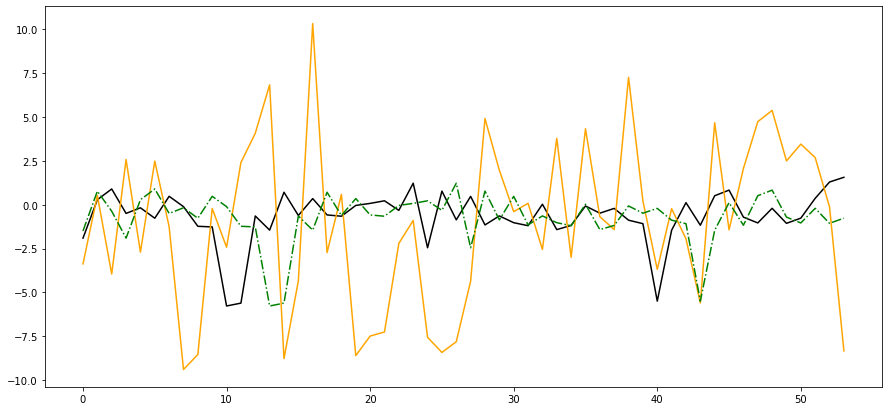

In [81]:
plt.figure(figsize = [15, 7])

naive = df_filtered_clr.iloc[-(test.shape[0]+lag):-lag]


plt.plot(test[col + '_lag0'].values, color = 'black')
plt.plot(ridge_results[col].values, color = 'orange')
plt.plot(naive[col].values, color = 'green', linestyle = '-.')

#### 2. LASSO REGRESSION

In [55]:
lasso_model = LassoModel(n_features)

lasso_results = lasso_model.test_model(train, test)
lasso_results.columns = df_filtered_clr.columns

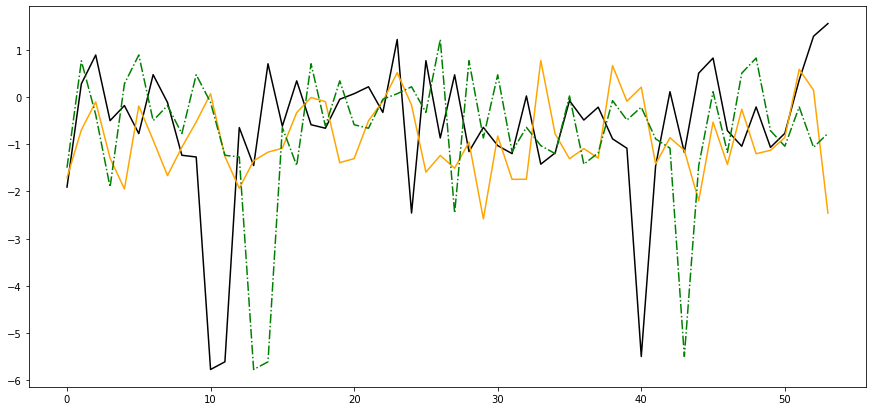

In [83]:
plt.figure(figsize = [15, 7])

plt.plot(test[col + '_lag0'].values, color = 'black')
plt.plot(lasso_results[col].values, color = 'orange')
plt.plot(naive[col].values, color = 'green', linestyle = '-.')

#### 3. ENET REGRESSION

In [84]:
enet_model = ENETModel(n_features)

enet_results = enet_model.test_model(train, test)
enet_results.columns = df_filtered_clr.columns

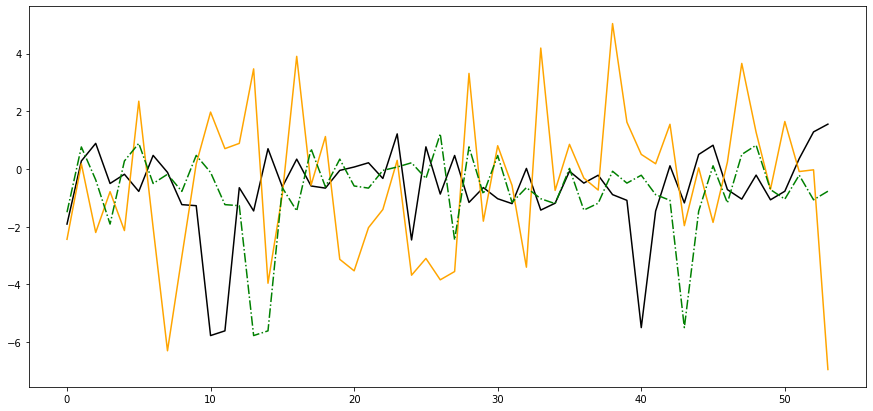

In [85]:
plt.figure(figsize = [15, 7])

plt.plot(test[col + '_lag0'].values, color = 'black')
plt.plot(enet_results[col].values, color = 'orange')
plt.plot(naive[col].values, color = 'green', linestyle = '-.')